In [1]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime as dt
from datetime import datetime

# Pull in stations and trips data sets using pandas to look at distribution of rides and locations 

In [2]:
stations = pd.read_csv('Nice_Ride_2017_Station_Locations.csv', low_memory = False)
trips = pd.read_csv('Nice_ride_trip_history_2017_season.csv', low_memory = False)

# Confirm the dataframe layout and how many rows each dataframe contains

In [3]:
print(stations.head(2))
print()
print("There are {} rows in the 2017 Nice Ride Station Locations data set.".format(len(stations)))
print()
print(trips.head(2))
print()
print("There are {} rows in the 2017 Nice Ride Trip History data set".format(len(trips)))
print()

  Number                      Name   Latitude  Longitude  Total docks
0  30000        100 Main Street SE  44.984892 -93.256551           27
1  30001  25th Street & 33rd Ave S  44.957341 -93.223374           15

There are 202 rows in the 2017 Nice Ride Station Locations data set.

        Start date                     Start station Start station number  \
0  11/5/2017 21:45   Hennepin Ave & S Washington Ave                30184   
1  11/5/2017 21:45  Broadway Street N & 4th Street E                30122   

          End date                       End station End station number  \
0  11/5/2017 22:02                        Logan Park              30104   
1  11/5/2017 22:26  Broadway Street N & 4th Street E              30122   

  Account type  Total duration (Seconds)  
0       Member                      1048  
1       Member                      2513  

There are 460718 rows in the 2017 Nice Ride Trip History data set



# We start with a very basic analysis - we just want to see if there is a difference in ridership tendencies between members and casual riders
* The first step is to simply make a copy of the *trips* datafame that we call *account_types*, this is a straightforward step
* We also change the "Start date" to a datetime for resampling the data by month (the first of many times we do this)

In [4]:
account_types = trips
account_types['Start date'] = pd.to_datetime(account_types['Start date'], format = "%m/%d/%Y %H:%M")

# We noticed when looking at the counts for each Account type, there is an additional type listed as "Inconnu"... this is most likely "unknown" so we just make this a "Casual" account type

In [5]:
account_types['Account type'].value_counts()

Member     290070
Casual     170646
Inconnu         2
Name: Account type, dtype: int64

In [6]:
account_types.loc[account_types['Account type']=='Inconnu', 'Account type'] = 'Casual'
account_types['Account type'].value_counts()

Member    290070
Casual    170648
Name: Account type, dtype: int64

# We group by Account type, resample the data so that it is monthly (since a daily view adds a lot of noise and doesn't provide a good picture), and get the count of rides and average ride time.
* We also rename the columns to make them easier to read when displaying them in a graph

In [7]:
members_vs_casuals = account_types.groupby('Account type').resample('M', on = 'Start date').agg({'Start station': 'count', 'Total duration (Seconds)': 'mean'}).reset_index()
members_vs_casuals.rename({'Start station': 'Total Number of Rides', 'Total duration (Seconds)': 'Average Ride Time (s)'}, axis = 'columns', inplace = True)
members_vs_casuals.head(1)

,Account type,Start date,Average Ride Time (s),Total Number of Rides
0,Casual,2017-04-30,3735.461743,10142


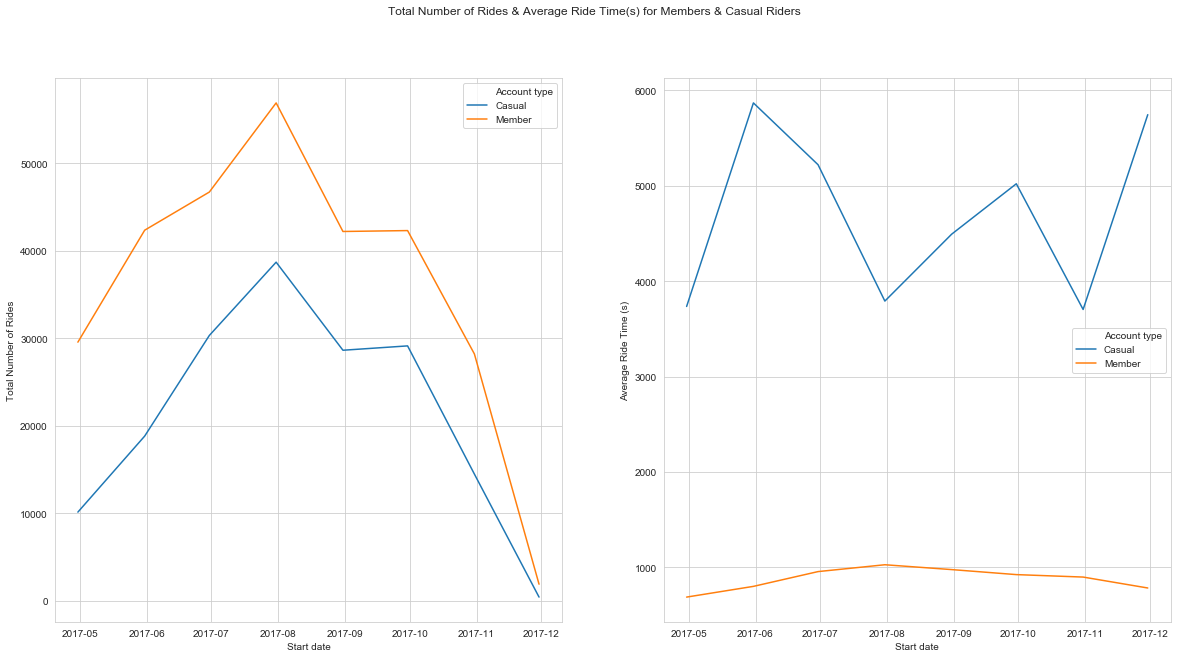

In [8]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(x = 'Start date', y = 'Total Number of Rides', hue = 'Account type', data = members_vs_casuals, ax = ax1)

sns.lineplot(x = 'Start date', y = 'Average Ride Time (s)', hue = 'Account type', data = members_vs_casuals, ax = ax2)

plt.suptitle('Total Number of Rides & Average Ride Time(s) for Members & Casual Riders')

plt.show()

# Our first analysis & initial observation!  We compare Total Number of Rides and Average Ride Time for Members and Casual Riders by month
* We find that Members take more rides throughout the course of the year, peaking right at the end of July 2017
* But even more interesting than that, we find that Casual riders take MUCH longer trips.  This tells us that Members are most likely commuting to nearby stations on their way to work, etc.

# Begin Station Layout and Analysis
* Create a "Location" column based on the latitudinal and longitudinal coordinates for each station

In [9]:
stations['Location'] = list(zip(stations['Latitude'], stations['Longitude']))
stations.head(1)

,Number,Name,Latitude,Longitude,Total docks,Location
0,30000,100 Main Street SE,44.984892,-93.256551,27,"(44.984891999999995, -93.256551)"


In [10]:
trips.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds)
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048


# Create initial map of dock stations by location, to get overall view of Nice Ride MN locations
* Notes:
    - **folium** library provides a fantastic way to visualize this data, using the coordinate data from the stations dataset
    - We create a *starting position* variable based on the center most station between the cities (this was after some trial and error)
    - We also create a *average_dock_count* variable and use it to differentiate whether a dock has more/less docks than the average
    - Hover-overs are included and display the dock location and how many docks available

In [11]:
starting_position = list(stations[stations['Name'] == 'Curfew Street & Ellis Ave.'].Latitude) + list(stations[stations['Name'] == 'Curfew Street & Ellis Ave.'].Longitude)

average_dock_count = stations['Total docks'].mean()

In [12]:
initial_folium_map = folium.Map(location=(starting_position),
                        zoom_start=13,
                        tiles="CartoDB positron")

for index, row in stations.iterrows():
    total_docks = row['Total docks']
    radius = total_docks/2
    
    popup_text = """
                Location: {}<br> 
                Total docks: {}<br>"""
    popup_text = popup_text.format(row["Name"],
                               row["Total docks"])
    
    
    if total_docks >= average_dock_count:
        color = "#E37222"
    else:
        color = "#0A8A9F"
    folium.CircleMarker(location=row['Location'], radius = radius, color = color, tooltip=popup_text).add_to(initial_folium_map)
    
initial_folium_map

# Pretty evenly spread across the Twin Cities, with three main hubs: downtown Minneapolis, the University of Minnesota - TC, and downtown St. Paul.  No surprises here.

# Merging the station data set with the trips data set to start tracking trips between locations
* Create a subset of the stations data set to merge since the key pieces are the station name, total number of docks, and the lat/long coordinates
* We merge on the trips data set twice, once for the "Start Location", and the second time for the "End Location"

In [13]:
stations_merge_df = stations[['Name', 'Total docks', 'Location']]
stations_merge_df.head(1)

,Name,Total docks,Location
0,100 Main Street SE,27,"(44.984891999999995, -93.256551)"


In [14]:
trips_merged = trips.merge(stations_merge_df, how = 'left', left_on = 'Start station', right_on = 'Name')
trips_merged.drop(labels = ['Name', 'Total docks'], axis = 1, inplace = True)
trips_merged.rename({'Location': 'Start Location'}, axis = 'columns', inplace = True)
trips_merged.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),Start Location
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048,"(44.981895, -93.269195)"


In [15]:
trips_merged = trips_merged.merge(stations_merge_df, how = 'left', left_on = 'End station', right_on = 'Name')
trips_merged.drop(labels = ['Name'], axis = 1, inplace = True)
trips_merged.rename({'Location': 'End Location'}, axis = 'columns', inplace = True)
trips_merged.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),Start Location,Total docks,End Location
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048,"(44.981895, -93.269195)",23,"(44.99882, -93.25276)"


# Change the Start & End dates to actual date values, and add a "Start" hour column to look at distributions based on time of day

In [16]:
trips_merged['Start Hour'] = pd.to_datetime(trips_merged['Start date'], format = "%m/%d/%Y %H:%M").dt.hour
trips_merged['Start date'] = pd.to_datetime(trips_merged['Start date'], format = "%m/%d/%Y %H:%M").dt.date
trips_merged['End date'] = pd.to_datetime(trips_merged['End date'], format = "%m/%d/%Y %H:%M").dt.date
trips_merged['Start date'] = pd.to_datetime(trips_merged['Start date'])
trips_merged['End date'] = pd.to_datetime(trips_merged['End date'])

# Create two new data frames, *outbound_trips* and *inbound_trips* by grouping on Date & Start/End Station Numbers
* We will use this to track usage for each station and determine if the "demand" meets the "supply" for the month of July below

In [17]:
outbound_trips = trips_merged.groupby(["Start date", "Start station number"], as_index = False)['Account type'].count()
outbound_trips.rename({'Account type': 'Outbound Trips'}, axis = 'columns', inplace = True)
outbound_trips.head(1)

,Start date,Start station number,Outbound Trips
0,2017-04-03,30000,6


In [18]:
inbound_trips = trips_merged.groupby(["End date", "End station number"], as_index = False)['Account type'].count()
inbound_trips.rename({'Account type': 'Inbound Trips'}, axis = 'columns', inplace = True)
inbound_trips.head(1)

,End date,End station number,Inbound Trips
0,2017-04-03,30000,6


# Merge the Inbound & Outbound trips together to get a cohesive picture of each stations daily net migration

In [19]:
all_station_trips = outbound_trips.merge(inbound_trips, how = "inner", 
                                         left_on = ['Start date', 'Start station number'], right_on = ['End date', 'End station number'])
all_station_trips.head(1)

,Start date,Start station number,Outbound Trips,End date,End station number,Inbound Trips
0,2017-04-03,30000,6,2017-04-03,30000,6


# Create *july_start* and *july_end* variables, and then subset the overall station trips data set for just the month of July.
* The reason for subsetting this data for July is it is the highest volume month, as seen in the earlier observations between Casual & Member riding behavior
* The variables can be changed for any month by simply updating the **month_start** and **month_end** variables
    - This will be useful in later analyses (or for colder months)

In [20]:
month_start = datetime.strptime('2017-07-01', '%Y-%m-%d')
month_end = datetime.strptime('2017-07-31', '%Y-%m-%d')
july_trips = all_station_trips[all_station_trips['Start date'].between(month_start, month_end)]
july_trips.head(1)

,Start date,Start station number,Outbound Trips,End date,End station number,Inbound Trips
14934,2017-07-01,30000,126,2017-07-01,30000,118


# We want visualize, for the month of July, whether each stations has roughly an equal amount of inbound and outbound trips, or if we can detect any anomalies
* This is the first of many uses of the **seaborn** library, that helps visualize the patterns in the data
* We measure the Outbound and Inbound trips on the same axis and look at it for each station by every day in July

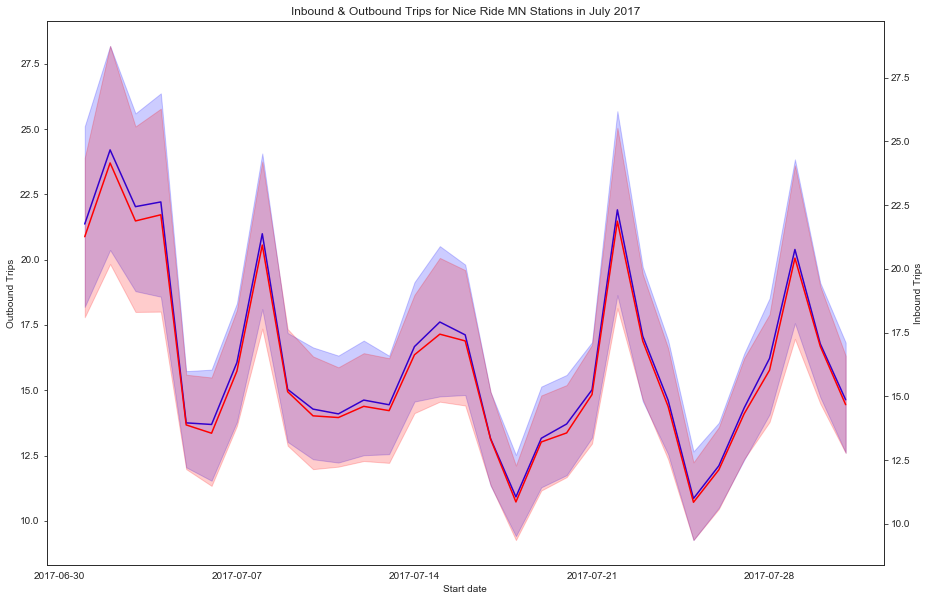

In [21]:
sns.set_style("white")

fig, ax1 = plt.subplots(figsize=(15, 10))

sns.lineplot(x = 'Start date', y = 'Outbound Trips', data = july_trips, ax = ax1, color = 'b')

ax2 = ax1.twinx()

sns.lineplot(x = 'Start date', y = 'Inbound Trips', data = july_trips, ax = ax2, color = 'r')

plt.title("Inbound & Outbound Trips for Nice Ride MN Stations in July 2017")

plt.show()

# The graph above looks fairly good - most stations handle their demand very well
# Our next step was to look how time of day might affect riders usage of each station... could we capture the heartbeat of the city?

# We start our approach by creating three more data frames based on our July data set; again, since it is the month with the highest usage, it's our best test case
- We go back to the overall trips data set to get location information, and again we subset this data set based on July only
- The *locations* dataframe is used to grab each station and their location
- We then create a *nine_am_departures* dataframe by subsetting our July data using the "Start Hour" we created earlier, to capture net departures from each station
- We follow this up with a *nine_am_arrivals* dataframe that behaves similarily, to capture net arrivals from each station

In [22]:
july_subset_location = trips_merged[trips_merged['Start date'].between(month_start, month_end)]

locations = july_subset_location.groupby("Start station number").first()
locations = locations.loc[:, ["Start Location","Start station"]]
locations.head(1)

,Start Location,Start station
Start station number,,
30000,"(44.984891999999995, -93.256551)",100 Main Street SE


In [23]:
nine_am_departures = july_subset_location[july_subset_location["Start Hour"]== 9]
july_departure_counts =  nine_am_departures.groupby("Start station number").count()
july_departure_counts = july_departure_counts.iloc[:,[0]]
july_departure_counts.columns = ["Outbound Trips"]
july_departure_counts.head(1)

,Outbound Trips
Start station number,
30000,51


In [24]:
nine_am_arrival = july_subset_location[july_subset_location["Start Hour"]== 9]
july_arrival_counts =  nine_am_arrival.groupby("End station number").count()
july_arrival_counts = july_arrival_counts.iloc[:,[0]]
july_arrival_counts.columns = ["Inbound Trips"]
july_arrival_counts.head(1)

,Inbound Trips
End station number,
30000,53


# Create a data frame of all arrivals and departures for each station in July 2017 @ 9AM (peak rush hour)

In [25]:
july_nine_am_rush_hour = july_departure_counts.join(locations).join(july_arrival_counts)
july_nine_am_rush_hour.head(1)

,Outbound Trips,Start Location,Start station,Inbound Trips
Start station number,,,,
30000,51,"(44.984891999999995, -93.256551)",100 Main Street SE,53.0


# Create a map displaying the arrivals and departures for each dock in the Twin Cities
* Tangerine signifies there were more outbound trips for that dock than inbound trips, so there was greater use of it to get to places
* Teal signifies that there were more inbound trips for that dock

In [26]:
nine_am_folium_map = folium.Map(location=starting_position,
                        zoom_start=13,
                        tiles="CartoDB positron")

for index, row in july_nine_am_rush_hour.iterrows():
    net_departures = (row["Outbound Trips"]-row["Inbound Trips"])
    radius = net_departures
    if net_departures > 0:
        color="#E37222"
    else:
        color="#0A8A9F"
        
    popup_text = """
                Name: {}<br> 
                Total Outbound Trips: {}<br>
                Total Inbound Trips: {}<br>
                Net Departures: {}"""
    popup_text = popup_text.format(row['Start station'],
                                   row['Outbound Trips'],
                                   row['Inbound Trips'],
                                   net_departures)
    
    folium.CircleMarker(location=(row["Start Location"]),
                        radius=radius,
                        color=color,
                        tooltip = popup_text,
                        fill=True).add_to(nine_am_folium_map)

nine_am_folium_map

# We re-create the same map for 5PM, again a peak time
* 9AM - 5PM being the standard working day, it makes sense to use these two time frames

In [27]:
five_pm_departures = july_subset_location[july_subset_location["Start Hour"]== 17]
july_departure_counts =  five_pm_departures.groupby("Start station number").count()
july_departure_counts = july_departure_counts.iloc[:,[0]]
july_departure_counts.columns = ["Outbound Trips"]

In [28]:
five_pm_arrivals = july_subset_location[july_subset_location["Start Hour"]== 17]
july_arrival_counts =  five_pm_arrivals.groupby("End station number").count()
july_arrival_counts = july_arrival_counts.iloc[:,[0]]
july_arrival_counts.columns = ["Inbound Trips"]

In [29]:
july_five_pm_rush_hour = july_departure_counts.join(locations).join(july_arrival_counts)
july_five_pm_rush_hour.head(1)

,Outbound Trips,Start Location,Start station,Inbound Trips
Start station number,,,,
30000,141,"(44.984891999999995, -93.256551)",100 Main Street SE,157


In [30]:
five_pm_folium_map = folium.Map(location=starting_position,
                        zoom_start=13,
                        tiles="CartoDB positron")

for index, row in july_five_pm_rush_hour.iterrows():
    net_departures = (row["Outbound Trips"]-row["Inbound Trips"])
    radius = net_departures
    if net_departures>0:
        color="#E37222" # tangerine
    else:
        color="#0A8A9F" # teal
    
    popup_text = """
                Name: {}<br> 
                Total Outbound Trips: {}<br>
                Total Inbound Trips: {}<br>
                Net Departures: {}"""
    popup_text = popup_text.format(row['Start station'],
                                   row['Outbound Trips'],
                                   row['Inbound Trips'],
                                   net_departures)
    
    folium.CircleMarker(location=(row["Start Location"]),
                        radius=radius,
                        color=color,
                        tooltip=popup_text,
                        fill=True).add_to(five_pm_folium_map)

five_pm_folium_map

# We've capture the heartbeat of the city!

# Next up in the analysis - comparing how many trips took place in 2017 and the amount of docks at each station... can we see any patterns in how many docks a station as and how many people use it?

* We begin by grouping the *trips* dataframe by the "Start" station and getting a simple count - this helps us understand each station's outbound usage for 2017.
    - We rename this column to "Outbound Trips in 2017" since this is what we captured
* We then do the same grouping of the *trips* dataframe but use the "End" station instead - this tells us each station's inbound usage for 2017
    - Similarily, we rename the column in the dataframe to "Inbound Trips in 2017"

In [31]:
start_station_trips = DataFrame(trips.groupby('Start station')['Start date'].count())
start_station_trips.rename({'Start date': 'Outbound Trips in 2017'}, axis = 'columns', inplace = True)
start_station_trips.head(1)

,Outbound Trips in 2017
Start station,
100 Main Street SE,8300


In [32]:
end_station_trips = DataFrame(trips.groupby('End station')['End date'].count())
end_station_trips.rename({'End date': 'Inbound Trips in 2017'}, axis = 'columns', inplace = True)
end_station_trips.head(1)

,Inbound Trips in 2017
End station,
100 Main Street SE,8539


# We then merge the two dataframes together to create an *all_trips* dataframe
* This contains *each* station's outbound & inbound trips for 2017
* We create one more column, "Total Trips in 2017" by adding the outbound & inbound trip columns together
* We then create a *stations_with_trip_counts* dataframe by merging the *stations* dataframe we create earlier (which contains the amount of docks for the station) with the *all_trips* dataframe

In [33]:
all_trips = start_station_trips.merge(end_station_trips, left_index = True, right_index = True)
all_trips.index.names = ['Station']
all_trips['Total Trips in 2017'] = all_trips['Outbound Trips in 2017'] + all_trips['Inbound Trips in 2017']
all_trips.head(1)

,Outbound Trips in 2017,Inbound Trips in 2017,Total Trips in 2017
Station,,,
100 Main Street SE,8300,8539,16839


In [34]:
stations_with_trip_counts = stations.merge(all_trips, how = 'left', left_on = 'Name', right_index = True)
stations_with_trip_counts.head(1)

,Number,Name,Latitude,Longitude,Total docks,Location,Outbound Trips in 2017,Inbound Trips in 2017,Total Trips in 2017
0,30000,100 Main Street SE,44.984892,-93.256551,27,"(44.984891999999995, -93.256551)",8300,8539,16839


# Using the *stations_with_trip_counts* dataframe, we can observe how the trips in 2017 were distributed based on the station's dock size
* We use seaborn again, and this time we use a **boxplot** to look help us visualize the distribution
* What do we notice?  Pretty clearly, a linear relationship between how many docks a station has and how many trips were taken from that station

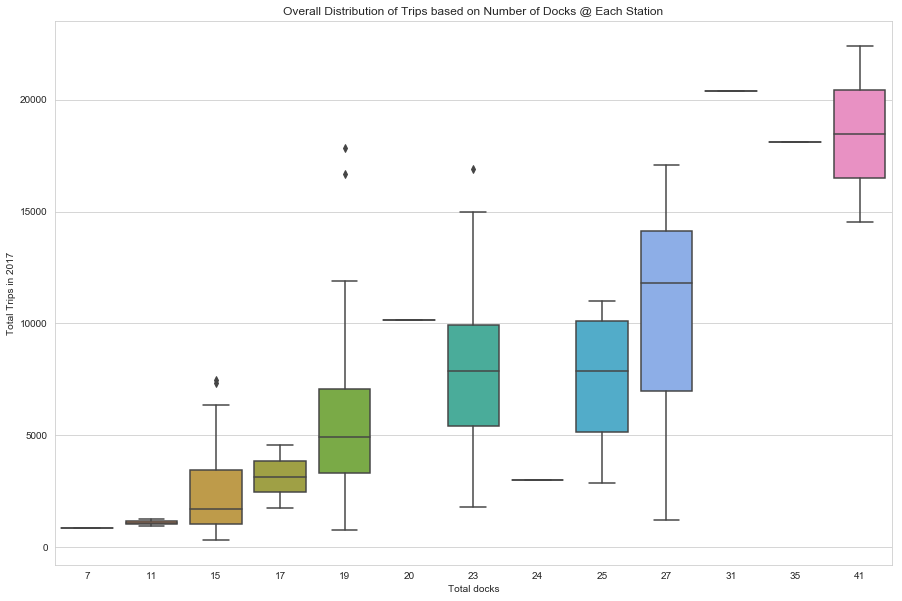

In [35]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(y = stations_with_trip_counts['Total Trips in 2017'], x = stations_with_trip_counts['Total docks'], ax = ax)

plt.title("Overall Distribution of Trips based on Number of Docks @ Each Station")

plt.show()

# Going one step further, we'll again group each station by dock size and look at the average number of trips taken from those stations... to confirm our observation above

In [36]:
by_docksize = stations_with_trip_counts.groupby('Total docks').mean().reset_index()
by_docksize = by_docksize[['Total docks', 'Total Trips in 2017']]
by_docksize.rename({'Total Trips in 2017': 'Average Number of Trips in 2017'}, axis = 'columns', inplace = True)
by_docksize.head(1)

,Total docks,Average Number of Trips in 2017
0,7,859.0


# Seaborn, back at it again!  What do we see?
* This time we use **regplot** to create a regression line for us - again, we're checking to see if there's a linear relationship between these two data points
* And what do you know!  Very clearly, the average number of trips follows a pretty linear path if you increase the amount of docks at the station

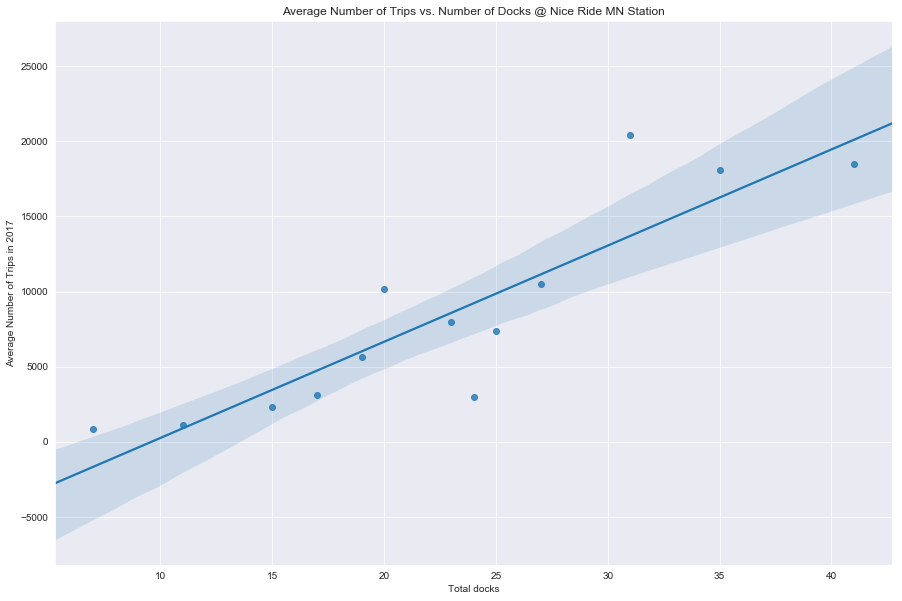

In [37]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(15, 10))

sns.regplot('Total docks', 'Average Number of Trips in 2017', data = by_docksize, ax = ax)

plt.title("Average Number of Trips vs. Number of Docks @ Nice Ride MN Station")

plt.show()

# Next up: look at the overall distribution of docks across the different stations - should they be more evenly distributed?
* To do that, we simply return to our *stations_with_trip_counts* dataframe since this contains every station and how many docks each station has
* We use seaborn's **distplot** function to build us a nice looking histogram
* What does this tell us?  That overwhemingly most dock stations have 15 docks at them, and doing a simple value count confirms that observation

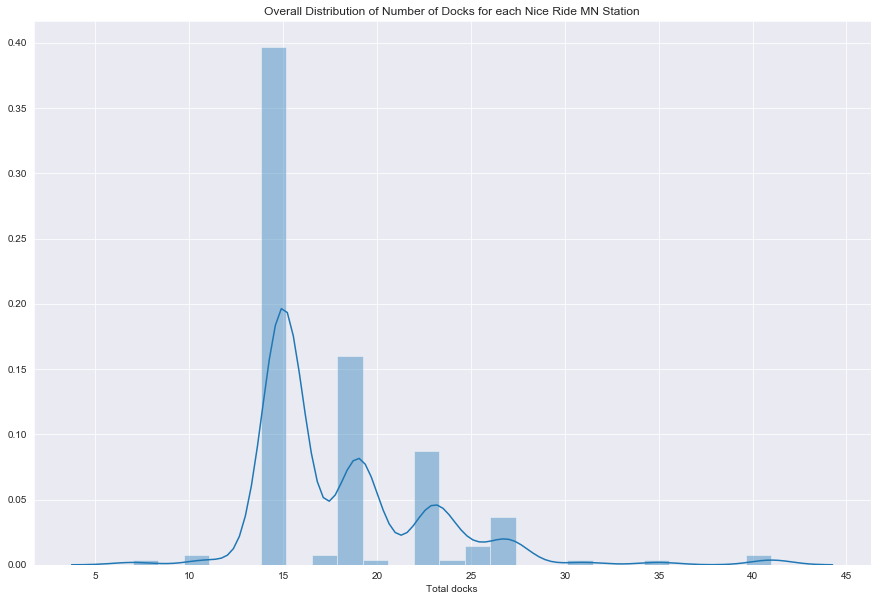

In [38]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(stations_with_trip_counts['Total docks'], ax = ax)

plt.title("Overall Distribution of Number of Docks for each Nice Ride MN Station")

plt.show()

In [39]:
stations_with_trip_counts['Total docks'].value_counts()

15    109
19     44
23     24
27     10
25      4
41      2
17      2
11      2
35      1
31      1
24      1
20      1
7       1
Name: Total docks, dtype: int64

# Next up: how does weather affect riding behavior?  As Minnesota residents, we know that even during the warmest months of the year, the weather can be quite volatile.  Does this influence a bike rider's behavior or are there people putting on their bravest face and meeting Mother Nature head on?

# We start by pulling in the two data sets we want to use to observe weather patterns and riding behavior
* You will see that the *trips* dataframe is created again; we want to initialize a new instance of this dataframe to start fresh
* We pull in the daily observed weather for Minneapolis for 2017; this gives us a lot of useful information including the level of precipitation, max temperature (F) & min temperature (F)

In [40]:
trips = pd.read_csv('Nice_ride_trip_history_2017_season.csv', low_memory = False)
weather = pd.read_csv('WeatherDailyMinneapolis2017.csv', low_memory = False)

In [41]:
print(trips.head(2))
print()
print("There are {} rows in the 2017 Nice Ride Trip History data set".format(len(trips)))
print()
print(weather.head(2))
print()
print("There are {} rows in the 2017 Daily Weather for Minneapolis data set".format(len(weather)))

        Start date                     Start station Start station number  \
0  11/5/2017 21:45   Hennepin Ave & S Washington Ave                30184   
1  11/5/2017 21:45  Broadway Street N & 4th Street E                30122   

          End date                       End station End station number  \
0  11/5/2017 22:02                        Logan Park              30104   
1  11/5/2017 22:26  Broadway Street N & 4th Street E              30122   

  Account type  Total duration (Seconds)  
0       Member                      1048  
1       Member                      2513  

There are 460718 rows in the 2017 Nice Ride Trip History data set

       STATION                              NAME        DATE  PRCP  TMAX  TMIN
0  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US  2017-01-01   0.0    26    18
1  USC00218450  UNIVERSITY OF MN ST. PAUL, MN US  2017-01-02   0.0    31    20

There are 365 rows in the 2017 Daily Weather for Minneapolis data set


# Update the Start and End Date fields to allow for merging to a complete dataset
* As mentioned above, we have to do quite a bit of data munging here to be able to merge the datasets together; having different date formats for each dataframe makes it so it is not a straightforward merge
* We convert the *trips* dataframe "Start" and "End" dates to a datetime format **first**
* We then create a copy of the *trips* dataframe to use for our merge with the *weather* dataframe, and again have to do some conversion of the "Start" and "End" dates to allow for a successful merge

In [42]:
trips['Start date'] = pd.to_datetime(trips['Start date'], format = "%m/%d/%Y %H:%M")
trips['End date'] = pd.to_datetime(trips['End date'], format = "%m/%d/%Y %H:%M")

trips_for_merge = trips
trips_for_merge['Start date'] = trips_for_merge['Start date'].dt.strftime('%Y-%m-%d')
trips_for_merge['End date'] = trips_for_merge['End date'].dt.strftime('%Y-%m-%d')

trips_for_merge.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds)
0,2017-11-05,Hennepin Ave & S Washington Ave,30184,2017-11-05,Logan Park,30104,Member,1048


In [43]:
weather.head(1)

,STATION,NAME,DATE,PRCP,TMAX,TMIN
0,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",2017-01-01,0.0,26,18


# We do some more clean up of the *weather* dataframe to merge with the *trips_for_merge* dataframe
* Only include revelant columns and relevant dates
    - **Date, Max Temp, Min Temp, Precipation Levels**
    - Then we only grab the dates that are relevant to us for these purposes, which are those days that actually had riders!

In [44]:
weather_for_merge = weather[['DATE', 'TMAX', 'TMIN', 'PRCP']]
weather_for_merge = weather_for_merge[weather_for_merge['DATE'].isin(trips_for_merge['End date'])]
weather_for_merge.head(1)

,DATE,TMAX,TMIN,PRCP
92,2017-04-03,53,43,0.0


# The *trips_weather_df* dataframe contains all of the information we'll need to make observations about trips & weather; it contains every trip for 2017 and that day's Max/Min Temperature and level of precipition

In [45]:
trips_weather_df = trips_for_merge.merge(weather_for_merge, how = 'left', left_on = 'Start date', right_on = 'DATE')
trips_weather_df.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),DATE,TMAX,TMIN,PRCP
0,2017-11-05,Hennepin Ave & S Washington Ave,30184,2017-11-05,Logan Park,30104,Member,1048,2017-11-05,41,33,0.1


# First up: we want to observe how max tempature affects the amount of riders and their ride times - do warmer days mean people are more likely to be out and out for longer durations?
* We have to do quite a bit of prep work before we can do that
    - We create a *bins* variable based on the lowest and highest observed max temperature for our dataframe to split our data more cleanly
    - Using the very useful *cut* method available in pandas, we can bucket each day into a specified temperature range

In [46]:
bins = np.arange(min(trips_weather_df.TMAX)-1, max(trips_weather_df.TMAX)+5, 5)
trips_weather_df['max_temp_range'] = pd.cut(trips_weather_df.TMAX, bins, right = False)
print("These are our 'buckets' for temperature ranges: {}".format(bins))
print()
print("And these are our temperature ranges:")
print()
print(trips_weather_df['max_temp_range'].cat.categories)

These are our 'buckets' for temperature ranges: [30 35 40 45 50 55 60 65 70 75 80 85 90 95]

And these are our temperature ranges:

IntervalIndex([[30, 35), [35, 40), [40, 45), [45, 50), [50, 55) ... [70, 75), [75, 80), [80, 85), [85, 90), [90, 95)]
              closed='left',
              dtype='interval[int64]')


# Now that we have each trip bucketed in a temperature, we can then move on and take a look at how that temperature range affects rider behavior
* We create a new dataframe *agg_by_max_temp* dataframe by grouping on the newly created "max_temp_range" column, and simply get an overall count and average ride time for each range

In [47]:
agg_by_max_temp = trips_weather_df.groupby('max_temp_range', 
                                           as_index = False).agg({'Start date': 'count', 'Total duration (Seconds)': 'mean'})
agg_by_max_temp.head(1)

,max_temp_range,Total duration (Seconds),Start date
0,"[30, 35)",1295.039691,1814


# To help us with our plotting, and to make this easier to understand, we have to do some more clean-up
* First, we create a "Max Temp (F)" column using our "max_temp_range"; here we're converting the column into a string, splitting it into two columns, grabbing the first value in the range, then splitting it again to remove the "[" 
* We then rename the columns to "Average Ride Time (s)" and "Total Number of Rides", again for more clarity in what we're observing


In [48]:
agg_by_max_temp['Max Temp (F)'] = agg_by_max_temp['max_temp_range'].astype(str).str.split(",", 
                                                                                            expand = True)[0].str.split("[", expand = True)[1].astype(int)
agg_by_max_temp.head(1)

,max_temp_range,Total duration (Seconds),Start date,Max Temp (F)
0,"[30, 35)",1295.039691,1814,30


In [49]:
agg_by_max_temp.rename({'Total duration (Seconds)': 'Average Ride Time (s)', 
                        'Start date': 'Total Number of Rides'}, axis = 'columns', inplace = True)
agg_by_max_temp.head(1)

,max_temp_range,Average Ride Time (s),Total Number of Rides,Max Temp (F)
0,"[30, 35)",1295.039691,1814,30


# Our big kahuna!  What do we see?
* We set up Total Number of Rides & Average Ride Time on the same axis, to compare it to Daily Max Temperature... and we see it steadily increase as the temperatures get warmer... but then suddenly there is big drop at 80°F... hmmm curiously we wonder if it may get too hot to be outside?

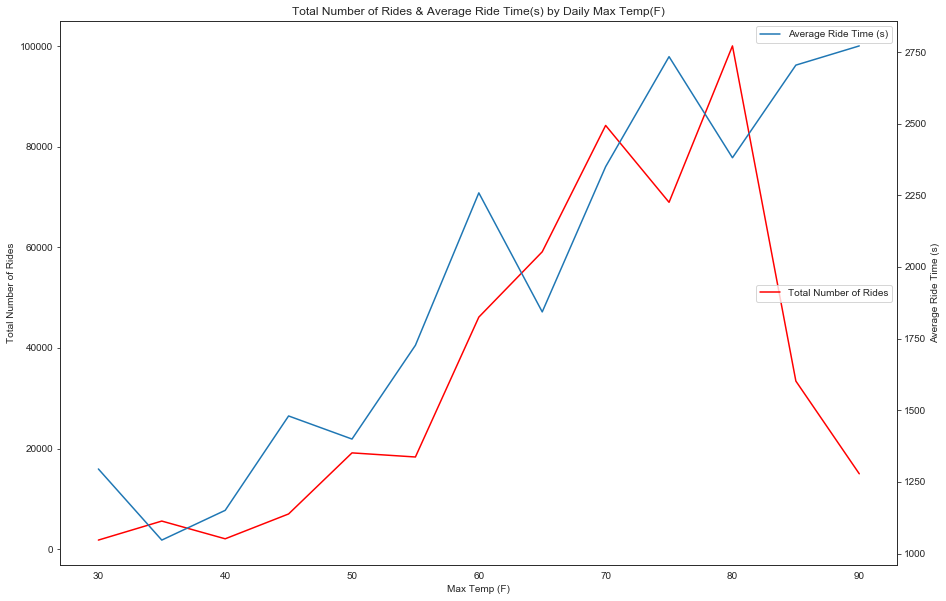

In [50]:
sns.set_style("white")

fig, ax1 = plt.subplots(figsize=(15, 10))

line1 = sns.lineplot(x = 'Max Temp (F)', y = 'Total Number of Rides', data = agg_by_max_temp, ax = ax1, color = 'r')

ax2 = ax1.twinx()

line2 = sns.lineplot(x = 'Max Temp (F)', y = 'Average Ride Time (s)', data = agg_by_max_temp, ax = ax2)

plt.title("Total Number of Rides & Average Ride Time(s) by Daily Max Temp(F)")
line2.legend(['Average Ride Time (s)'])
line1.legend(['Total Number of Rides'], loc = 5)

plt.show()

# Next up: looking at rider participation by the level of percipitation... do rainy day blues affect our riders?
* We create another aggregated dataframe *agg_by_precip*, similarily to our *agg_by_max_temp* dataframe

In [51]:
agg_by_precip = trips_weather_df.groupby('PRCP', as_index = False).agg({'Total duration (Seconds)': 'mean', 'TMAX': 'mean', 'Account type': 'count'})
agg_by_precip.head(1)

,PRCP,Total duration (Seconds),TMAX,Account type
0,0.0,2298.421738,73.36567,311907


# Again, we have to do some renaming of the columns so that they are easily understood
* Something else that we found - overwhemingly riders were out when there was no observed precipitation, or no rain... so much so that the scale of the data when graphing was quite skewed
* We made the decision to remove "0" precipitation from the data set to be used for plotting, to account for this and adjust the view

In [52]:
agg_by_precip.rename({'PRCP':'Precipitation', 'Total duration (Seconds)': 'Average Ride Time (s)', 
                     'TMAX':'Average Max Temp (F)', 'Account type': 'Total Number of Rides'}, axis = 'columns', inplace = True)
agg_by_precip = agg_by_precip[agg_by_precip['Precipitation'] != min(agg_by_precip['Precipitation'])]
agg_by_precip.head(1)

,Precipitation,Average Ride Time (s),Average Max Temp (F),Total Number of Rides
1,0.01,2021.535134,74.13281,16437


# So what do we see?  
## On the left, we have the total number of rides for each level of observed precipitation.. many more rides on the days where there is little to no rain... which makes sense to us
## On the right, we have the average ride time for each level of observed precipitation... here the data skews pretty wildly, there doesn't seem to be much of a pattern

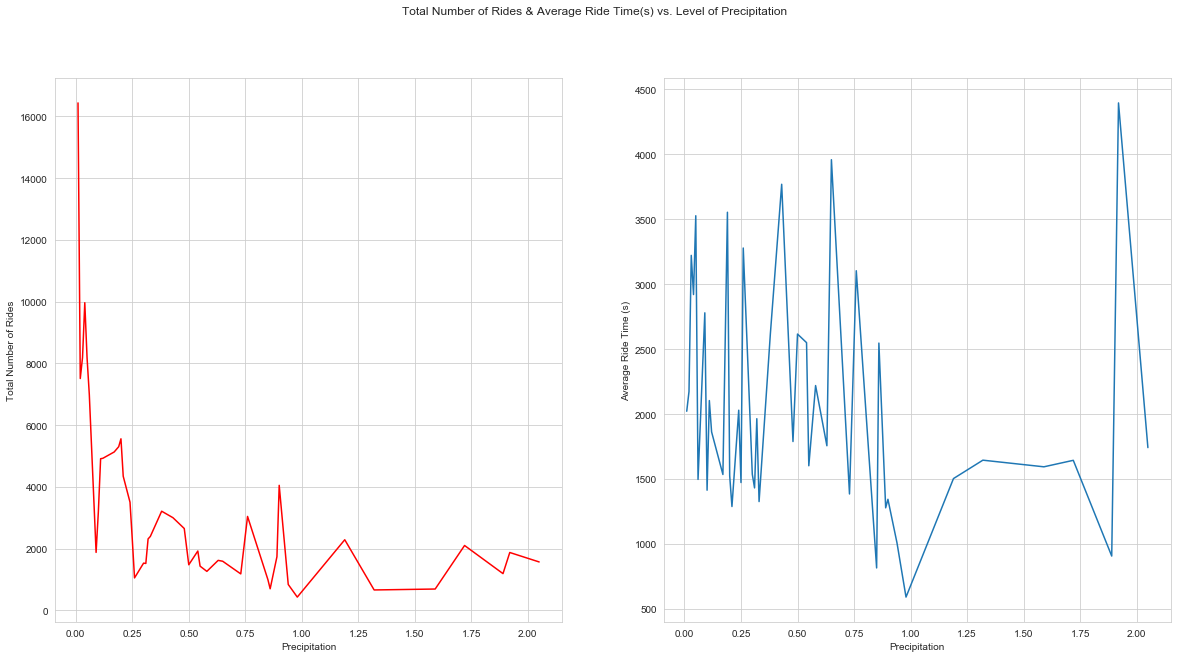

In [53]:
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.lineplot(x = 'Precipitation', y = 'Total Number of Rides', data = agg_by_precip, ax = ax1, color = 'r')

sns.lineplot(x = 'Precipitation', y = 'Average Ride Time (s)', data = agg_by_precip, ax = ax2)

fig.suptitle("Total Number of Rides & Average Ride Time(s) vs. Level of Precipitation")

plt.show()

# After seeing such strange riding behavior, we went to one more possible influence on riding behavior.... day of the week
* We create a *day_of_week* dataframe using a copy of our *trips_weather_df* dataframe
* We once again create a datetime field using the "Start date" column, which we assign back to itself
* We then create a "Day of Week" column using datetime and getting the week day from the "Start date"

In [54]:
day_of_week = trips_weather_df
day_of_week['Start date'] = pd.to_datetime(day_of_week['Start date'])
day_of_week['Day of Week'] = day_of_week['Start date'].dt.weekday_name
day_of_week.head(1)

,Start date,Start station,Start station number,End date,End station,End station number,Account type,Total duration (Seconds),DATE,TMAX,TMIN,PRCP,max_temp_range,Day of Week
0,2017-11-05,Hennepin Ave & S Washington Ave,30184,2017-11-05,Logan Park,30104,Member,1048,2017-11-05,41,33,0.1,"[40, 45)",Sunday


# A lot to unpack in this step, so we'll go slowly
* First, we aggregate by the day of the week and create an *agg_day_of_week* dataframe, and get our observations - counts and average ride time
* We rename our columns as we have done above for consistency and readability
* We then to reorganize our data so it follows the normal format of a week, going from Monday - Sunday
    - If we don't do this, then graphing the data is all over the place
    - If Monday is our first row in the dataset, it's a success!

In [55]:
agg_day_of_week = day_of_week.groupby('Day of Week', as_index = False).agg({'Start station number': 'count', 'Total duration (Seconds)': 'mean'})
agg_day_of_week.rename({'Start station number': 'Total Number of Rides', 
                        'Total duration (Seconds)': 'Average Ride Time(s)'}, axis = 'columns', inplace = True)

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

agg_day_of_week['Day of Week'] = pd.Categorical(agg_day_of_week['Day of Week'], categories = cats, ordered = True)
agg_day_of_week.sort_values(by = 'Day of Week', inplace = True)
agg_day_of_week.head(1)

,Day of Week,Average Ride Time(s),Total Number of Rides
1,Monday,2006.683292,59408


# Seaborn, again, makes this visual look really great
## On the left, we created a barplot for the total number of rides for each day of the week, and the data seems to validate our assumption - weekends see an increase in usage & riders
## On the right, we observe that the average ride times are **heavily** influenced by weekends.... our riders spend much more time riding around on weekends than during the week!

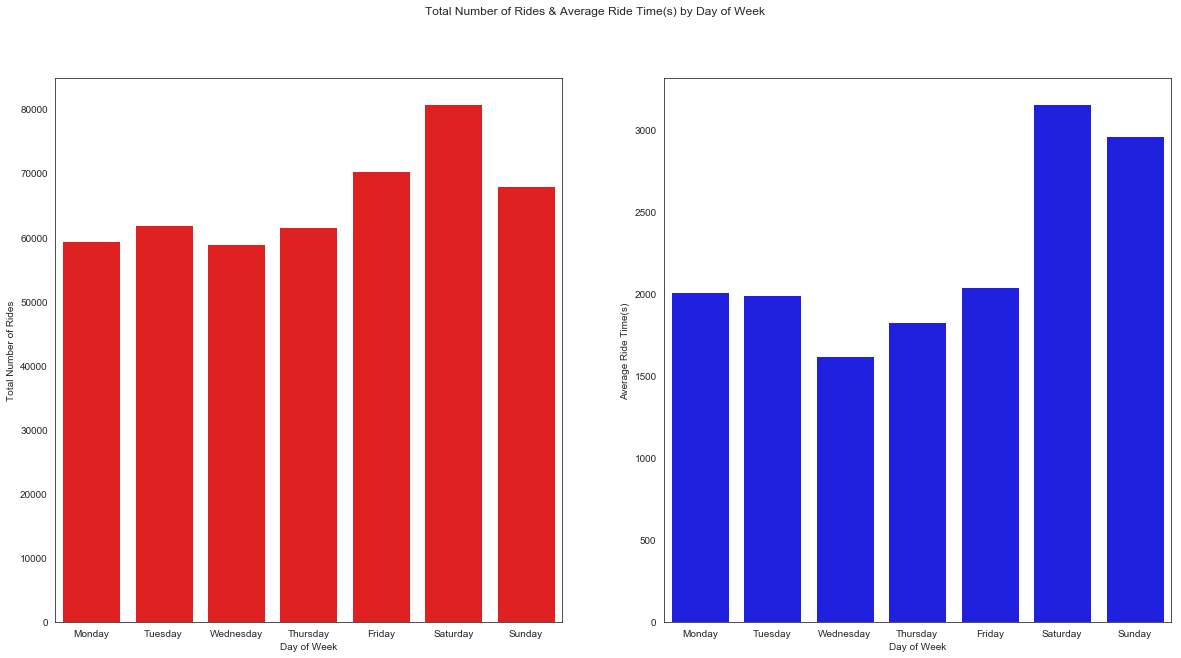

In [56]:
sns.set_style("white")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(x = 'Day of Week', y = 'Total Number of Rides', data = agg_day_of_week, ax = ax1, color = 'r')

sns.barplot(x = 'Day of Week', y = 'Average Ride Time(s)', data = agg_day_of_week, ax = ax2, color = 'b')

fig.suptitle("Total Number of Rides & Average Ride Time(s) by Day of Week")

plt.show()